In [ ]:
# default_exp load_data
# %reload_ext autoreload
# %autoreload 2
from nbdev.showdoc import show_doc
!date

Wed Aug 18 09:24:16 PDT 2021


# Load data
> Prepare photons and exposure, given a source 

This module defines the function `load_source_data`.

Depends on module Exposure for SC data 

In [ ]:
#export
import pickle, healpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wtlike.config import (Config, UTC, MJD)
from wtlike.exposure import  binned_exposure, sc_data_selection


In [ ]:
# export
def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source

    - source : a PointSource object
    - week : dict with
        - tzero : start time for the photon
        - photon_df : DataFrame with photon data

    Returns a DF with
    - `band` index,
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing
    - `radius` distance in deg from source direction
    """

    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix

    center, conepix = _cone(config,source)

    df = week['photons']
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)

    if sum(incone)<2:
        if config.verbose>1:
            print(f'\nWeek starting {UTC(MJD(tstart))} has 0 or 1 photons')
        return

    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone].copy()

    if 'trun' in dfc:
        time = dfc.run_id.astype(float) + dfc.trun * config.offset_size
    else:
        # old: convert  to float, add tstart, convert to MJD
        time = np.array(dfc.time, float)+tstart
    dfc.loc[:,'time'] = MJD(time)

    # assemble the DataFrame, remove those outside the radius
    out_df = dfc

    # make sure times are monotonic by sorting (needed since runs not in order in most
    #  week-files after March 2018)
    out_df = dfc.sort_values(by='time')

    if config.verbose>2:
        print(f'selected photons:\n{out_df.head()}')

    return out_df

In [ ]:
# export
class ProcessWeek(object):
    """
    Process a week    
    """
  
    def __init__(self, config, source, week_file): #, carry_in=np.zeros(32)): 
        """
        
        """
        with open(week_file, 'rb') as inp:
            week = pickle.load(inp)
        pdf = week['photons']
        sc_data = edf = week['sc_data']
        self.start = MJD(week['tstart'])
        self.config = config

        if config.verbose>1:
            print(f'Opened week file "{week_file.name}" of {UTC(self.start)}')
            print(f'\tFound {len(pdf):,} photons, {len(edf):,} SC entries)')
        
        self.sc_df = sc_df = sc_data_selection(config, source, sc_data)
        
        # interleaved start/stop 
        self.stime = np.empty(2*len(sc_df.start))
        self.stime[0::2]=sc_df.start.values
        self.stime[1::2]=sc_df.stop.values
        assert np.all(np.diff(self.stime)>=0), 'Time-ordering failure'

        self.lt = sc_df.livetime.values
        self.ct = sc_df.cos_theta.values
        

        pdf = _get_photons_near_source(config,source, week)
        if pdf is None or len(pdf)<3 :
            self.photons = None
        else:
            assert pdf is not None and len(pdf)>0
            
            # set weights from the weight table, removing those with no weight            
            pdf = source.wtman.add_weights(pdf)
            
            # finally set the time and the exposure per remaining photons
            self.photons = self.photon_times( pdf )
            
    def __repl__(self):
        return f'Data for week of {UTF(self.start)}: {len(self.photons):,} photons'
    
    def __str__(self): return self.__repl__()
        
    def photon_times(self, pdf):
        
        # construct the time from the run number and offset
        ptime = MJD(pdf.run_id.astype(float) + pdf.trun * self.config.offset_size)
        pdf.loc[:,'time'] = ptime

        # select the subset with exposure info
        tk = np.searchsorted(self.stime, ptime)
        good_exp = np.mod(tk,2)==1
        pdfg = pdf[good_exp].copy()
        if len(pdfg)==0:
            return None
        pdfg.drop(columns=['trun'], inplace=True)
        # time edges-- same for each band
        #xp = np.append(self.stime[0::2],self.stime[-1]) 
        
        return pdfg
    
    def hist_spacecraft(self):
        self.sc_df.hist('livetime cos_theta exp'.split(), bins=100, layout=(1,3), figsize=(12,3));
        
    def hist_photons(self):
        self.photons.hist('band time'.split(), bins=100, log=True, figsize=(12,3), layout=(1,3));
        
       
    def __call__(self):
        return dict(
            start= self.start,
            photons=self.photons, 
            exposure=self.sc_df,

        )

In [ ]:
#export
def get_week_files(config, week_range=None):
    """
    """
    data_folder = config.datapath/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    weeks = week_range or  config.week_range
    if week_range is not None:

        slc = slice(*week_range) if type(week_range)==tuple else slice(week_range,week_range)
        wk_table = pd.Series(data=[df for df in data_files],
                     index= [ int(df.name[-7:-4]) for df in  data_files],
                    )
        data_files = wk_table.loc[slc].values

        if config.verbose>0:
            q = lambda x: x if x is not None else ""
            print(f'LoadData: Loading weeks[{q(slc.start)}:{q(slc.stop)}:{q(slc.step)}]', end='' if config.verbose<2 else '\n')
    else:
        if config.verbose>0: print(f'LoadData: loading all {len(data_files)} weekly files')
    
    if len(data_files)==0:
        msg =  f'Specified week_range {week_range} produced no output. Note that week numbers are 9-'
        raise Exception(msg)

    return data_files

In [ ]:
#export
def load_source_data(config, source, week_range=None, key='', clear=False):
    """
    This is a client of SourceData. 
    
    - week_range [None] -- if None, select all weeks
    - key ['']   -- key to use for cache, construct from name if not set      
    - clear [False]
    
    Returns a tuple of
    - photons
    - exposure

    """

    if config.datapath/'data_files' is None and key not in config.cache:
        raise Exception(f'Data for {source.name} is not cached, and config.datapath/"data_files" is not set')

    def load_from_weekly_data(config, source, week_range=None):

        week_files = get_week_files(config, week_range) 
        pp = []
        ee = []

        for week_file in week_files:
            if config.verbose<2: print('.', end='')
            elif config.verbose>=2:
                print(f'Loading file {week_file}-----')

            wk = ProcessWeek(config, source, week_file)

            # append week data to photons, weighted exposure, band exposure
            pdf = wk.photons
            edf = wk.sc_df
            if pdf is not None and len(pdf)>2:
                pp.append(pdf)
            if len(edf)>0:
                ee.append(edf)

        print('');

        # concatenate the two lists of DataFrames
        p_df = pd.concat(pp, ignore_index=True)
        p_df.loc[:,'run_id'] = pd.Categorical(p_df.run_id)
        e_df = pd.concat(ee, ignore_index=True)

        return p_df, e_df
    description=f'SourceData:  {source.name}'
    
    if week_range is not None or key is None:
        # always load directly if weeks specified or key set to None
        print(description)
        r = load_from_weekly_data(config, source, week_range=week_range)
    else:
        # use the cache
        key = f'{source.filename}_data' if key=='' else key
        r = config.cache(key,
                    load_from_weekly_data, config, source, week_range=None,
                    overwrite=clear,
                    description=description)
    return r

### Develop incremental update, using weeks
Also try multiprocessing

In [ ]:
#hide 
class TWeek():
    def __init__(self, config, source):
        self.config=config
        self.source=source
        
    def __call__(self, wkf):
        print('.', end='')
        eman = ProcessWeek( self.config, self.source, wkf)
        return (eman.photons, eman.sc_df)
    
def get_week_data(config, source, week_range, processes=1):
    
    from multiprocessing import Pool
    
    week_files = get_week_files(config,  week_range) 
    txt = f', with multiprocessing, {processes} processes' if processes>1 else ''
    print(f'Processing {len(week_files)} files{txt}')
    
    process_week = TWeek(config, source)
    
    if processes>1:
        with Pool(processes=processes) as pool:
            week_data = pool.map(process_week, week_files)
    else:
        week_data = map(process_week,  week_files)
    print('\n')
    
    pp = []
    ee = []

    for wk in week_data:
        # append week data to photons, weighted exposure, band exposure
        pdf,edf = wk
        if pdf is not None and len(pdf)>2:
            pp.append(pdf)
        if len(edf)>0:
            ee.append(edf)

    return pp,ee

In [ ]:
# #hide
# config = Config()
# from wtlike.sources import PointSource
# week_range = (9,508)
# source = PointSource('Geminga')
# config.verbose=0
# !date
# pp,ee = get_week_data(config, source, week_range)
# !date

In [ ]:
# !date
# pp,ee = get_week_data(config, source, week_range, processes=8)
# !date

In [ ]:
#hide
# config=Config(); config.verbose=1
# source =PointSource('Geminga', config=config) 
# t = load_source_data(config, source, week_range=None, key='Geminga_test', clear=False )

### Test with a Geminga week

WeightMan: file from source "PSR B1259-63"_weights.pkl : 16 bamds with nsides 64 to 1024
LoadData: Loading weeks[665:665:]
Opened week file "week_665.pkl" of 2021-02-25 01:07
	Found 390,687 photons, 17,026 SC entries)
	Found 17,026 S/C entries:  5,176 remain after zenith and theta cuts
Set up flux-weigted exposure for 4FGL J1302.9-6349
WeightMan: processing 4,672 photons
	remove 3,102 events without weight


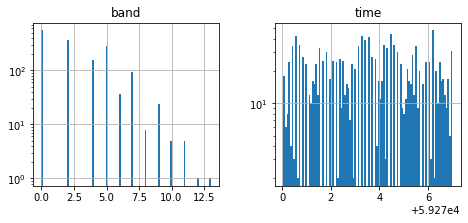

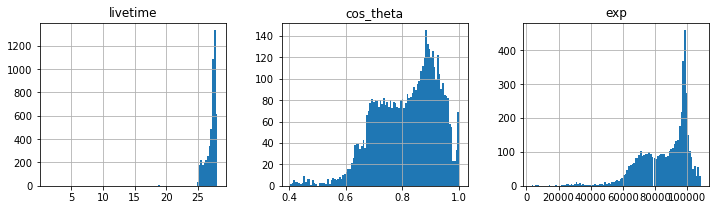

In [ ]:
#hide
config=Config(); config.verbose=2
name="Geminga"
name='PSR B1259-63'
if config.valid:
    # testing
    from wtlike.sources import PointSource
    source =PointSource(name, config=config) 
    week_files = get_week_files(config, (665,665)); 
    week_file = week_files[0]
    self = ProcessWeek(config, source, week_file)

    self.hist_photons()
    self.hist_spacecraft()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Wed Aug 18 09:24:29 PDT 2021
